In [1]:
# Bibliothèques usuelles pour analyse de données et modélisation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Configuration pour les tracés
#plt.style.use("seaborn-whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)


In [2]:
# Importation des données simulées et observées
matrix_1 = np.load('data/matrix_1.npy')
matrix_2 = np.load('data/matrix_2.npy')
matrix_3 = np.load('data/matrix_3.npy')
matrix_4 = np.load('data/matrix_4.npy')

# Importation des labels correspondants
label_models       = np.load('data/label_models.npy')
label_past_times   = np.load('data/label_past_times.npy')
label_future_times = np.load('data/label_future_times.npy')

In [3]:
data_simulated_past      = matrix_3
data_simulated_future    = matrix_1
data_observed_past       = matrix_2
data_observed_past_sigma = matrix_4


In [137]:
label_past_times,label_future_times

(array(['1850', '1851', '1852', '1853', '1854', '1855', '1856', '1857',
        '1858', '1859', '1860', '1861', '1862', '1863', '1864', '1865',
        '1866', '1867', '1868', '1869', '1870', '1871', '1872', '1873',
        '1874', '1875', '1876', '1877', '1878', '1879', '1880', '1881',
        '1882', '1883', '1884', '1885', '1886', '1887', '1888', '1889',
        '1890', '1891', '1892', '1893', '1894', '1895', '1896', '1897',
        '1898', '1899', '1900', '1901', '1902', '1903', '1904', '1905',
        '1906', '1907', '1908', '1909', '1910', '1911', '1912', '1913',
        '1914', '1915', '1916', '1917', '1918', '1919', '1920', '1921',
        '1922', '1923', '1924', '1925', '1926', '1927', '1928', '1929',
        '1930', '1931', '1932', '1933', '1934', '1935', '1936', '1937',
        '1938', '1939', '1940', '1941', '1942', '1943', '1944', '1945',
        '1946', '1947', '1948', '1949', '1950', '1951', '1952', '1953',
        '1954', '1955', '1956', '1957', '1958', '1959', '1960', 

## 3.1 Mise en forme des données/3.2 moyenne multi modèle

In [28]:
# Indices correspondant aux années souhaitées
idx_X = np.where((label_past_times >= np.datetime64("1950")) &
                 (label_past_times <= np.datetime64("2000")))[0]

idx_Y = np.where((label_future_times >= np.datetime64("2090")) &
                 (label_future_times <= np.datetime64("2099")))[0]

# Moyenne observée entre 1950 et 2000
X_obs = np.array([[data_observed_past[0, idx_X].mean()]])  # shape (1, 1)


# Moyenne entre 1950 et 2000 pour chaque modèle (X)
X = data_simulated_past[:, idx_X].mean(axis=1, keepdims=True)  # shape (25, 1)

# Moyenne entre 2090 et 2099 pour chaque modèle (Y)
Y = data_simulated_future[:, idx_Y].mean(axis=1, keepdims=True)  # shape (25, 1)

# Moyenne multi-modèle sur la période 2090–2099
Y_mean = Y.mean()  # scalaire
Y_std = Y.std()    # écart-type (variabilité inter-modèle)

print(f"Moyenne multi-modèle (2090–2099) : {Y_mean:.3f} °C")
print(f"Écart-type inter-modèle          : {Y_std:.3f} °C")

Moyenne multi-modèle (2090–2099) : 5.221 °C
Écart-type inter-modèle          : 1.036 °C


## Moyenne ponderee

In [30]:
# Paramètres libres à ajuster
sigma_D = 0.5   # contrôle la sensibilité au critère de performance
sigma_S = 0.4 # contrôle la sensibilité au critère d'indépendance

# Calcul des distances de performance (D_i = |X_i - X_obs|)
D = np.abs(X.flatten() - X_obs.flatten()[0])  # shape (25,)

# Calcul de la matrice des distances d'indépendance (S_ij = |X_i - X_j|)
S = np.abs(X - X.T)  # shape (25, 25)

# Numerateur des poids : performance (exp(-D_i^2 / sigma_D^2))
numerator = np.exp(- D**2 / sigma_D**2)  # shape (25,)

# Dénominateur des poids : dépendance (somme sur j de exp(-S_ij^2 / sigma_S^2))
denominator = np.sum(np.exp(- S**2 / sigma_S**2), axis=1)  # shape (25,)

# Poids non normalisés
w_raw = numerator / denominator

# Normalisation pour que la somme des poids soit 1
w = w_raw / np.sum(w_raw)

# Estimation finale de Y (moyenne pondérée)
Y_hat = np.sum(w * Y.flatten())

# Estimation de la variance pondérée
var_hat = np.sum(w * (Y.flatten() - Y_hat)**2)
std_hat = np.sqrt(var_hat)

# Résultats
print(f"Estimation pondérée de Y : {Y_hat:.3f} °C")
print(f"Incertitude associée (écart-type pondéré) : {std_hat:.3f} °C")


Estimation pondérée de Y : 5.250 °C
Incertitude associée (écart-type pondéré) : 1.049 °C


In [31]:
# Plages de valeurs à tester
sigma_D_list = [0.01, 0.05, 0.1, 0.2, 0.5]
sigma_S_list = [0.01, 0.05, 0.1, 0.2, 0.5]

# Stockage des résultats
results = []

for sigma_D in sigma_D_list:
    for sigma_S in sigma_S_list:
        # --- Calcul des poids pondérés ---

        # Distance performance
        D = np.abs(X.flatten() - X_obs.flatten()[0])

        # Matrice des distances d'indépendance
        S = np.abs(X - X.T)

        # Poids : critère performance
        perf = np.exp(- D**2 / sigma_D**2)

        # Poids : critère d'indépendance
        indep = np.sum(np.exp(- S**2 / sigma_S**2), axis=1)

        # Poids combinés
        w_raw = perf / indep
        w = w_raw / np.sum(w_raw)

        # Estimation et incertitude
        Y_hat = np.sum(w * Y.flatten())
        std_hat = np.sqrt(np.sum(w * (Y.flatten() - Y_hat)**2))

        # Stocker le résultat
        results.append((sigma_D, sigma_S, Y_hat, std_hat))

# Affichage sous forme de tableau
import pandas as pd

df_results = pd.DataFrame(results, columns=["sigma_D", "sigma_S", "Y_hat", "std_hat"])
df_results = df_results.sort_values(["sigma_D", "sigma_S"]).reset_index(drop=True)
display(df_results)


,sigma_D,sigma_S,Y_hat,std_hat
0,0.01,0.01,4.945850,0.001250
1,0.01,0.05,4.945851,0.001517
2,0.01,0.10,4.945851,0.001602
3,0.01,0.20,4.945851,0.001663
4,0.01,0.50,4.945851,0.001656
5,0.05,0.01,5.054518,1.094746
6,0.05,0.05,5.100250,1.189146
7,0.05,0.10,5.275146,1.184957
8,0.05,0.20,5.320930,1.188328
9,0.05,0.50,5.309529,1.189825


In [33]:
# Valeurs à tester
alpha_list = [0.1, 0.2, 0.3, 0.5, 0.7, 1.0]
beta_list = [0.1, 0.2, 0.3, 0.5, 0.7, 1.0]

# Stockage des résultats
results = []

std_X = np.std(X)

for alpha in alpha_list:
    for beta in beta_list:
        sigma_D = alpha * std_X
        sigma_S = beta * std_X

        # Performance
        D = np.abs(X.flatten() - X_obs.flatten()[0])
        perf = np.exp(- D**2 / sigma_D**2)

        # Indépendance
        S = np.abs(X - X.T)
        indep = np.sum(np.exp(- S**2 / sigma_S**2), axis=1)

        # Poids et prédiction
        w_raw = perf / indep
        w = w_raw / np.sum(w_raw)

        Y_hat = np.sum(w * Y.flatten())
        std_hat = np.sqrt(np.sum(w * (Y.flatten() - Y_hat)**2))

        results.append((alpha, beta, sigma_D, sigma_S, Y_hat, std_hat))

# Affichage des résultats
df_method1 = pd.DataFrame(results, columns=["alpha", "beta", "sigma_D", "sigma_S", "Y_hat", "std_hat"])
df_method1 = df_method1.sort_values(["alpha", "beta"]).reset_index(drop=True)
display(df_method1)


,alpha,beta,sigma_D,sigma_S,Y_hat,std_hat
0,0.1,0.1,0.021606,0.021606,5.001036,0.421324
1,0.1,0.2,0.021606,0.043213,5.016326,0.458224
2,0.1,0.3,0.021606,0.064819,5.027547,0.467601
3,0.1,0.5,0.021606,0.108032,5.038017,0.480172
4,0.1,0.7,0.021606,0.151245,5.043221,0.488935
5,0.1,1.0,0.021606,0.216064,5.045156,0.492592
6,0.2,0.1,0.043213,0.021606,5.011846,1.096218
7,0.2,0.2,0.043213,0.043213,5.094525,1.140434
8,0.2,0.3,0.043213,0.064819,5.218098,1.138626
9,0.2,0.5,0.043213,0.108032,5.311694,1.134314


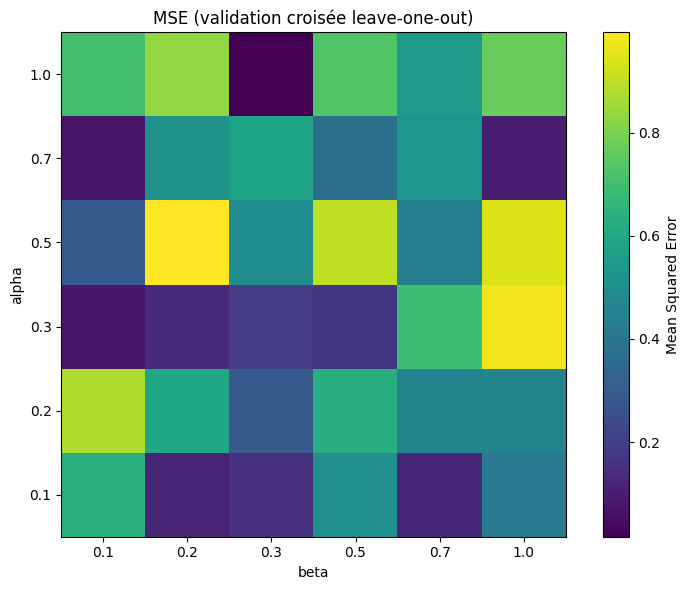

In [46]:
# Simulation de df_cv comme si le code précédent avait été exécuté
# Ces données doivent être remplacées par les vraies données de ton environnement
alpha_grid = [0.1, 0.2, 0.3, 0.5, 0.7, 1.0]
beta_grid = [0.1, 0.2, 0.3, 0.5, 0.7, 1.0]



# Matrice de MSE pour heatmap
mse_grid = df_cv_test.pivot(index="alpha", columns="beta", values="mse")

# Tracé heatmap
fig, ax = plt.subplots(figsize=(8, 6))
c = ax.imshow(mse_grid.values, origin='lower', cmap='viridis')

# Axes et labels
ax.set_xticks(np.arange(len(beta_grid)))
ax.set_yticks(np.arange(len(alpha_grid)))
ax.set_xticklabels(beta_grid)
ax.set_yticklabels(alpha_grid)
ax.set_xlabel("beta")
ax.set_ylabel("alpha")
ax.set_title("MSE (validation croisée leave-one-out)")
fig.colorbar(c, ax=ax, label="Mean Squared Error")

plt.tight_layout()
plt.show()


In [47]:
# Meilleurs paramètres trouvés
alpha_opt = 1.0
beta_opt = 0.3
sigma_D = alpha_opt * np.std(X)
sigma_S = beta_opt * np.std(X)

# Calcul des poids sur X_obs avec tous les modèles
D = np.abs(X.flatten() - X_obs.flatten()[0])
perf = np.exp(- D**2 / sigma_D**2)

S = np.abs(X - X.T)
indep = np.sum(np.exp(- S**2 / sigma_S**2), axis=1)

w_raw = perf / indep
w = w_raw / np.sum(w_raw)

Y_hat = np.sum(w * Y.flatten())
std_hat = np.sqrt(np.sum(w * (Y.flatten() - Y_hat)**2))

print(f"Projection finale (Y_hat) : {Y_hat:.3f} °C")
print(f"Incertitude associée (écart-type) : {std_hat:.3f} °C")


Projection finale (Y_hat) : 5.166 °C
Incertitude associée (écart-type) : 1.130 °C


## Regressions lineaire

In [57]:
# Régression linéaire sur (X, Y)
reg = LinearRegression()
reg.fit(X, Y)

# Coefficients
a = reg.coef_[0][0]   # pente
b = reg.intercept_[0] # ordonnée à l'origine

print(f"Modèle ajusté : Y = {a:.3f} * X + {b:.3f}")

# Prédiction pour X_obs avec le modèle ajusté
Y_obs_hat = reg.predict(X_obs)
print(f"Projection future à partir de X_obs : {Y_obs_hat[0][0]:.3f} °C")

# Nombre de modèles
M = len(X)

# Moyenne et dispersion de X
X_mean = np.mean(X)
S_xx = np.sum((X - X_mean)**2)

# Prédictions sur Y
Y_pred = reg.predict(X)

# Estimation de s^2 (variance résiduelle corrigée)
residuals = Y - Y_pred
s_squared = np.sum(residuals**2) / (M - 2)

# Formule complète pour l'incertitude de la prédiction
X0 = X_obs[0, 0]
sigma_squared = s_squared * (1 + 1/M + ((X0 - X_mean)**2 / S_xx))
std_regression = np.sqrt(sigma_squared)

print(f"Incertitude (écart-type) associée à la prédiction : {std_regression:.3f} °C")

Modèle ajusté : Y = 0.658 * X + 5.017
Projection future à partir de X_obs : 5.298 °C
Incertitude (écart-type) associée à la prédiction : 1.097 °C


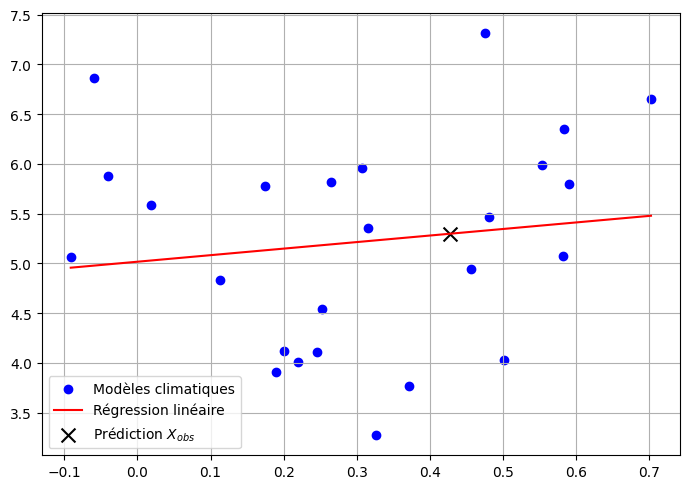

0.01879947254293257

In [61]:
# Tracé du nuage de points
plt.figure(figsize=(7, 5))
plt.scatter(X, Y, color='blue', label='Modèles climatiques')

# Tracé de la droite de régression
X_line = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
Y_line = reg.predict(X_line)
plt.plot(X_line, Y_line, color='red', label='Régression linéaire')

# Point de prédiction pour X_obs
plt.scatter(X_obs, Y_obs_hat, color='black', marker='x', s=100, label='Prédiction $X_{obs}$')

# Mise en forme

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

r2_score(Y, reg.predict(X))

## Kalman

In [66]:
# Moyennes sur les simulations
mu_X = X.mean()
mu_Y = Y.mean()

# Écarts types (intra-modèle)
sigma_X = X.std(ddof=1)
sigma_Y = Y.std(ddof=1)

# Corrélation entre X et Y
rho = np.corrcoef(X.flatten(), Y.flatten())[0, 1]

# Observation réelle
X0 = X_obs[0, 0]

# Incertitude de l'observation : on prend la moyenne de sigma sur 1950–2000
sigma_B = matrix_4[100:151].mean()

# Estimation de Y (espérance conditionnelle)
numerateur = rho * sigma_Y * sigma_X
denominateur = sigma_Y**2 + sigma_X**2
Y_hat_kalman = mu_Y + (numerateur / denominateur) * (X0 - mu_X)

# Estimation de l'incertitude associée
ratio = sigma_B**2 / sigma_X**2
reduction = rho**2 / (1 + ratio)
sigma_hat_kalman = np.sqrt((1 - reduction) * sigma_Y**2)

# Affichage
print(f"Projection Kalman : {Y_hat_kalman:.3f} °C")
print(f"Incertitude associée : {sigma_hat_kalman:.3f} °C")


Projection Kalman : 5.224 °C
Incertitude associée : 1.048 °C


## Validation croisée

### Moyenne pondérée

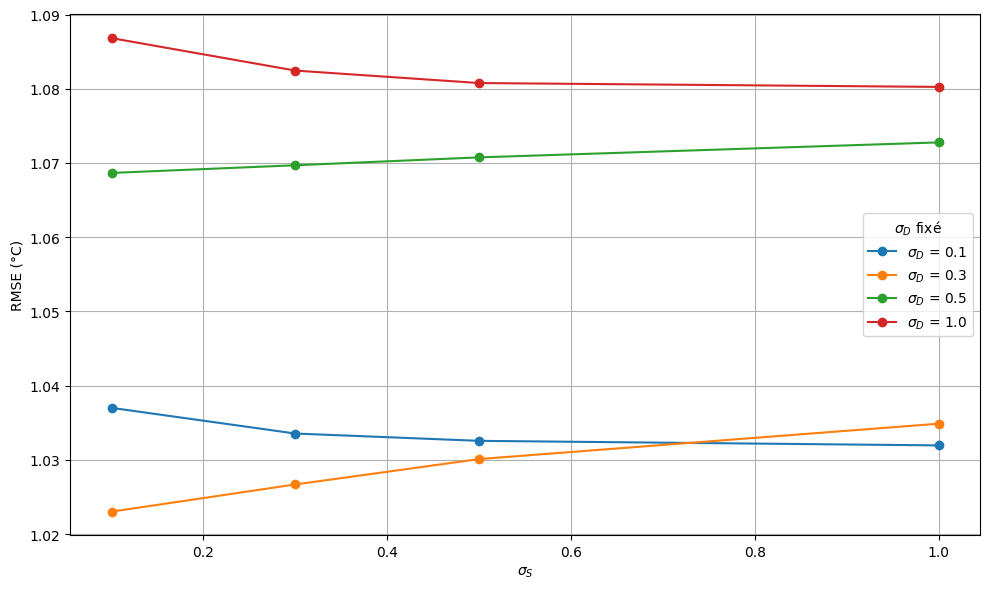

In [79]:
# Grilles de valeurs à tester
sigma_D_values = [0.1, 0.3, 0.5, 1.0]
sigma_S_values = [0.1, 0.3, 0.5, 1.0]

# Stocker les résultats pour le tracé
results = []

for sigma_D in sigma_D_values:
    for sigma_S in sigma_S_values:
        loo_squared_errors = []

        for i in range(len(X)):
            X_train = np.delete(X, i, axis=0)
            Y_train = np.delete(Y, i, axis=0)
            X_test = X[i, 0]
            Y_test = Y[i, 0]

            D = np.abs(X_train.flatten() - X_test)
            S = np.abs(X_train - X_train.T)

            numerator = np.exp(- D**2 / sigma_D**2)
            denominator = np.sum(np.exp(- S**2 / sigma_S**2), axis=1)
            w_raw = numerator / denominator
            w = w_raw / np.sum(w_raw)

            Y_pred = np.sum(w * Y_train.flatten())
            loo_squared_errors.append((Y_pred - Y_test)**2)

        mse_loo = np.mean(loo_squared_errors)
        rmse_loo = np.sqrt(mse_loo)

        results.append((sigma_D, sigma_S, rmse_loo))

# Tracé
fig, ax = plt.subplots()
for sigma_D in sigma_D_values:
    filtered = [(s, rmse) for d, s, rmse in results if d == sigma_D]
    sigma_S_list = [s for s, rmse in filtered]
    rmse_list = [rmse for s, rmse in filtered]
    ax.plot(sigma_S_list, rmse_list, marker='o', label=f"$\\sigma_D$ = {sigma_D}")

ax.set_xlabel("$\\sigma_S$")
ax.set_ylabel("RMSE (°C)")
ax.legend(title="$\\sigma_D$ fixé")
ax.grid(True)
plt.tight_layout()
plt.show()


### regression linéare

In [82]:
n = len(X)
loo_squared_errors = []

for i in range(n):
    # Séparation apprentissage/test
    X_train = np.delete(X, i, axis=0)
    Y_train = np.delete(Y, i, axis=0)
    X_test = X[i].reshape(1, -1)
    Y_test = Y[i, 0]

    # Ajustement de la régression sur les n−1 points
    reg = LinearRegression()
    reg.fit(X_train, Y_train)

    # Prédiction du point laissé de côté
    Y_pred = reg.predict(X_test)[0, 0]

    # Erreur quadratique
    loo_squared_errors.append((Y_pred - Y_test)**2)

# Moyenne et racine carrée
mse_loo = np.mean(loo_squared_errors)
rmse_loo = np.sqrt(mse_loo)

print(f"Erreur quadratique moyenne LOO : {mse_loo:.3f}")
print(f"Erreur quadratique moyenne racine LOO (RMSE) : {rmse_loo:.3f} °C")


Erreur quadratique moyenne LOO : 1.250
Erreur quadratique moyenne racine LOO (RMSE) : 1.118 °C


### Kalman

In [85]:
loo_squared_errors = []

# Incertitude observationnelle fixée (même pour chaque X_i)
# Si tu veux vraiment adapter sigma_B à chaque X_i, précise-le
sigma_B = matrix_4[100:151].mean()

for i in range(len(X)):
    # Exclure le i-ème modèle
    X_train = np.delete(X, i, axis=0)
    Y_train = np.delete(Y, i, axis=0)

    X_i = X[i, 0]
    Y_i = Y[i, 0]

    # Recalcul des paramètres à chaque itération
    mu_X = X_train.mean()
    mu_Y = Y_train.mean()
    sigma_X = X_train.std(ddof=1)
    sigma_Y = Y_train.std(ddof=1)
    rho = np.corrcoef(X_train.flatten(), Y_train.flatten())[0, 1]

    # Gain de Kalman
    gain = (rho * sigma_Y * sigma_X) / (sigma_Y**2 + sigma_X**2)

    # Prédiction pour X_i
    Y_hat_i = mu_Y + gain * (X_i - mu_X)

    # Stockage de l'erreur
    loo_squared_errors.append((Y_hat_i - Y_i)**2)

# Moyenne et racine carrée
mse_loo = np.mean(loo_squared_errors)
rmse_loo = np.sqrt(mse_loo)

print(f"Erreur quadratique moyenne LOO : {mse_loo:.3f}")
print(f"Erreur quadratique moyenne racine LOO (RMSE) : {rmse_loo:.3f} °C")


Erreur quadratique moyenne LOO : 1.167
Erreur quadratique moyenne racine LOO (RMSE) : 1.080 °C


### Données brutes(Y)

In [6]:
loo_squared_errors = []

for i in range(len(Y)):
    Y_train = np.delete(Y, i, axis=0)
    Y_test = Y[i, 0]

    Y_pred = np.mean(Y_train)
    loo_squared_errors.append((Y_pred - Y_test)**2)

mse_loo = np.mean(loo_squared_errors)
rmse_loo = np.sqrt(mse_loo)

print(f"Erreur quadratique moyenne LOO (brute) : {mse_loo:.3f}")
print(f"Erreur quadratique moyenne racine LOO (RMSE) : {rmse_loo:.3f} °C")


Erreur quadratique moyenne LOO (brute) : 1.165
Erreur quadratique moyenne racine LOO (RMSE) : 1.079 °C


## Modification du predicteur X

In [10]:
# Conversion des labels en chaînes d'années
label_str = np.array([str(y) for y in label_past_times.astype('datetime64[Y]')])

# Indices des périodes
idx_2002_2021 = np.isin(label_str, [str(y) for y in range(2002, 2022)])
idx_1922_2021 = np.isin(label_str, [str(y) for y in range(1922, 2022)])

# Prédicteur court (2002–2021)
X_1 = data_simulated_past[:, idx_2002_2021].mean(axis=1).reshape(-1, 1)
X_1_obs = data_observed_past[:, idx_2002_2021].mean().reshape(1, 1)
X_1_std = data_simulated_past[:, idx_2002_2021].mean(axis=1).std(ddof=1)

# Prédicteur long (1922–2021)
X_2 = data_simulated_past[:, idx_1922_2021].mean(axis=1).reshape(-1, 1)
X_2_obs = data_observed_past[:, idx_1922_2021].mean().reshape(1, 1)
X_2_std = data_simulated_past[:, idx_1922_2021].mean(axis=1).std(ddof=1)

# Affichage
print(f"X_1 (2002–2021) — Moyenne multi-modèle : {X_1.mean():.3f}, écart-type : {X_1_std:.3f}")
print(f"X_1_obs        — Observation : {X_1_obs[0,0]:.3f}")
print(f"X_2 (1922–2021) — Moyenne multi-modèle : {X_2.mean():.3f}, écart-type : {X_2_std:.3f}")
print(f"X_2_obs        — Observation : {X_2_obs[0,0]:.3f}")


X_1 (2002–2021) — Moyenne multi-modèle : 1.053, écart-type : 0.254
X_1_obs        — Observation : 1.053
X_2 (1922–2021) — Moyenne multi-modèle : 0.421, écart-type : 0.189
X_2_obs        — Observation : 0.512


### Regression lineaire

In [13]:
def regression_lineaire(X, Y, X_obs, label):
    reg = LinearRegression()
    reg.fit(X, Y)

    # Coefficients
    a = reg.coef_[0][0]
    b = reg.intercept_[0]
    print(f"{label} — Modèle : Y = {a:.3f} * X + {b:.3f}")

    # Prédiction pour X_obs
    Y_obs_hat = reg.predict(X_obs)[0, 0]
    print(f"{label} — Prédiction à partir de X_obs : {Y_obs_hat:.3f} °C")

    # Incertitude associée
    n = len(X)
    Y_pred = reg.predict(X)
    residuals = Y - Y_pred
    sigma_squared = np.sum(residuals**2) / (n - 2)
    X_mean = np.mean(X)
    S_xx = np.sum((X - X_mean)**2)
    X0 = X_obs[0, 0]
    var_pred = sigma_squared * (1/n + ((X0 - X_mean)**2) / S_xx)
    std_pred = np.sqrt(var_pred)

    print(f"{label} — Incertitude associée (écart-type) : {std_pred:.3f} °C\n")


# Application pour les deux prédicteurs
regression_lineaire(X_1, Y, X_1_obs, "X₁ (2002–2021)")
regression_lineaire(X_2, Y, X_2_obs, "X₂ (1922–2021)")

X₁ (2002–2021) — Modèle : Y = 2.212 * X + 2.893
X₁ (2002–2021) — Prédiction à partir de X_obs : 5.222 °C
X₁ (2002–2021) — Incertitude associée (écart-type) : 0.183 °C

X₂ (1922–2021) — Modèle : Y = 1.144 * X + 4.740
X₂ (1922–2021) — Prédiction à partir de X_obs : 5.325 °C
X₂ (1922–2021) — Incertitude associée (écart-type) : 0.236 °C



### Moyenne pond

In [15]:
# Liste de couples à tester
sigma_values = [(0.1, 0.1), (0.3, 0.3), (0.5, 0.4), (1.0, 0.5)]

def moyenne_ponderee_resultats(X, X_obs, Y, label):
    print(f"--- {label} ---")
    for sigma_D, sigma_S in sigma_values:
        D = np.abs(X.flatten() - X_obs.flatten()[0])
        S = np.abs(X - X.T)

        numerator = np.exp(- D**2 / sigma_D**2)
        denominator = np.sum(np.exp(- S**2 / sigma_S**2), axis=1)
        w_raw = numerator / denominator
        w = w_raw / np.sum(w_raw)

        Y_hat = np.sum(w * Y.flatten())
        var_hat = np.sum(w * (Y.flatten() - Y_hat)**2)
        std_hat = np.sqrt(var_hat)

        print(f"σ_D={sigma_D}, σ_S={sigma_S} → Ŷ = {Y_hat:.3f} °C, σ̂ = {std_hat:.3f} °C")
    print()

# Test avec les deux prédicteurs
moyenne_ponderee_resultats(X_1, X_1_obs, Y, "X₁ (2002–2021)")
moyenne_ponderee_resultats(X_2, X_2_obs, Y, "X₂ (1922–2021)")

--- X₁ (2002–2021) ---
σ_D=0.1, σ_S=0.1 → Ŷ = 5.534 °C, σ̂ = 0.568 °C
σ_D=0.3, σ_S=0.3 → Ŷ = 5.219 °C, σ̂ = 0.950 °C
σ_D=0.5, σ_S=0.4 → Ŷ = 5.226 °C, σ̂ = 1.022 °C
σ_D=1.0, σ_S=0.5 → Ŷ = 5.245 °C, σ̂ = 1.053 °C

--- X₂ (1922–2021) ---
σ_D=0.1, σ_S=0.1 → Ŷ = 5.055 °C, σ̂ = 0.989 °C
σ_D=0.3, σ_S=0.3 → Ŷ = 5.233 °C, σ̂ = 1.057 °C
σ_D=0.5, σ_S=0.4 → Ŷ = 5.256 °C, σ̂ = 1.045 °C
σ_D=1.0, σ_S=0.5 → Ŷ = 5.264 °C, σ̂ = 1.036 °C



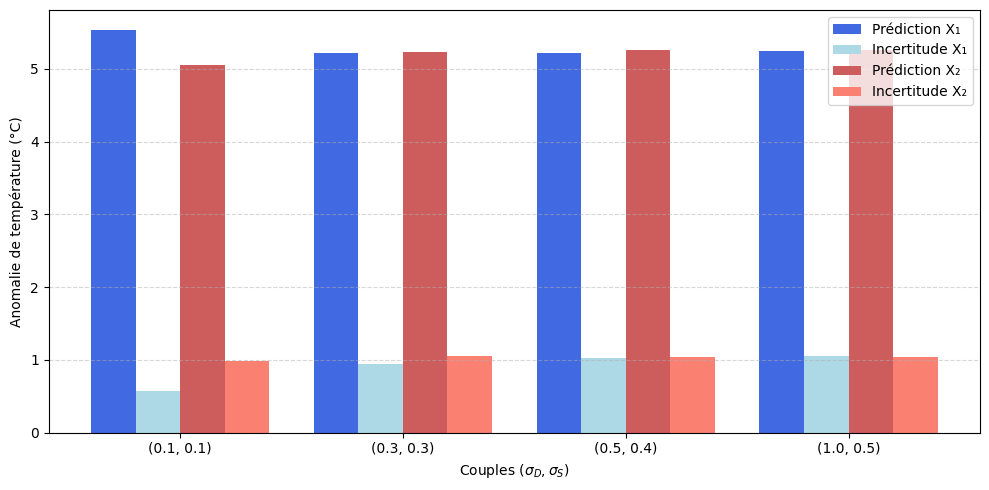

In [19]:
def plot_predictions_and_uncertainties(couples, results_X1, results_X2):
    labels = [f"({sd}, {ss})" for sd, ss in couples]
    x = np.arange(len(labels))  # positions des groupes

    # Données
    pred_X1 = [r[0] for r in results_X1]
    std_X1  = [r[1] for r in results_X1]
    pred_X2 = [r[0] for r in results_X2]
    std_X2  = [r[1] for r in results_X2]

    bar_width = 0.2

    plt.figure(figsize=(10, 5))
    plt.bar(x - 1.5*bar_width, pred_X1, width=bar_width, label='Prédiction X₁', color='royalblue')
    plt.bar(x - 0.5*bar_width, std_X1, width=bar_width, label='Incertitude X₁', color='lightblue')
    plt.bar(x + 0.5*bar_width, pred_X2, width=bar_width, label='Prédiction X₂', color='indianred')
    plt.bar(x + 1.5*bar_width, std_X2, width=bar_width, label='Incertitude X₂', color='salmon')

    plt.xticks(x, labels)
    plt.ylabel("Anomalie de température (°C)")
    plt.xlabel("Couples $(\\sigma_D, \\sigma_S)$")
    plt.legend()
    plt.grid(True, axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

couples = [(0.1, 0.1), (0.3, 0.3), (0.5, 0.4), (1.0, 0.5)]
results_X1 = [(5.534, 0.568), (5.219, 0.950), (5.226, 1.022), (5.245, 1.053)]
results_X2 = [(5.055, 0.989), (5.233, 1.057), (5.256, 1.045), (5.264, 1.036)]

plot_predictions_and_uncertainties(couples, results_X1, results_X2)

### Kaldman

In [22]:
def kalman_projection(X, Y, X_obs, matrix_4, idx_range, label):
    # Statistiques des simulations
    mu_X = X.mean()
    mu_Y = Y.mean()
    sigma_X = X.std(ddof=1)
    sigma_Y = Y.std(ddof=1)
    rho = np.corrcoef(X.flatten(), Y.flatten())[0, 1]

    # Observation réelle
    X0 = X_obs[0, 0]

    # Incertitude d'observation sur X_obs (sigma_B)
    sigma_B = matrix_4[idx_range].mean()

    # Projection par filtre de Kalman
    gain = (rho * sigma_Y * sigma_X) / (sigma_Y**2 + sigma_X**2)
    Y_hat = mu_Y + gain * (X0 - mu_X)

    # Incertitude associée
    snr_ratio = sigma_B**2 / sigma_X**2
    reduction = rho**2 / (1 + snr_ratio)
    sigma_hat = np.sqrt((1 - reduction) * sigma_Y**2)

    print(f"{label} — Projection Kalman : {Y_hat:.3f} °C")
    print(f"{label} — Incertitude associée : {sigma_hat:.3f} °C\n")


# Déterminer les indices temporels correspondants
years = np.array([int(str(y)) for y in label_past_times.astype('datetime64[Y]')])
idx_range_X1 = np.where((years >= 2002) & (years <= 2021))[0]
idx_range_X2 = np.where((years >= 1922) & (years <= 2021))[0]

# Appliquer la méthode de Kalman
kalman_projection(X_1, Y, X_1_obs, matrix_4, idx_range_X1, "X₁ (2002–2021)")
kalman_projection(X_2, Y, X_2_obs, matrix_4, idx_range_X2, "X₂ (1922–2021)")


X₁ (2002–2021) — Projection Kalman : 5.221 °C
X₁ (2002–2021) — Incertitude associée : 0.896 °C

X₂ (1922–2021) — Projection Kalman : 5.224 °C
X₂ (1922–2021) — Incertitude associée : 1.036 °C



## Tendance des simulations

In [30]:
# Étape 1 : repérage des indices pour 2002–2021
years = np.array([int(str(y)) for y in label_past_times.astype('datetime64[Y]')])
idx_2002_2021 = np.where((years >= 2002) & (years <= 2021))[0]
t_range = np.arange(len(idx_2002_2021)).reshape(-1, 1)  # valeurs t = 0,1,...,19

# Étape 2 : calcul des pentes pour chaque modèle simulé
X_trends = []
for i in range(data_simulated_past.shape[0]):
    y = data_simulated_past[i, idx_2002_2021].reshape(-1, 1)
    reg = LinearRegression().fit(t_range, y)
    slope = reg.coef_[0][0]
    X_trends.append(slope)
X_trends = np.array(X_trends).reshape(-1, 1)  # forme (25, 1)

# Étape 3 : pente pour l'observation réelle
y_obs = data_observed_past[:, idx_2002_2021].reshape(-1, 1)
reg_obs = LinearRegression().fit(t_range, y_obs)
X_trend_obs = np.array([[reg_obs.coef_[0][0]]])  # forme (1, 1)

# Résumé
X = X_trends
X_obs = X_trend_obs
Y = Y_mean_future

# Vérification
print(f"Pente moyenne multi-modèle (2002–2021) : {X.mean():.5f}")
print(f"Pente observée (2002–2021) : {X_obs[0, 0]:.5f}")

Pente moyenne multi-modèle (2002–2021) : 0.02936
Pente observée (2002–2021) : 0.02104


In [31]:
# Étape 5 : calcul Kalman
mu_X = X.mean()
mu_Y = Y.mean()
sigma_X = X.std(ddof=1)
sigma_Y = Y.std(ddof=1)
rho = np.corrcoef(X.flatten(), Y.flatten())[0, 1]
sigma_B = data_observed_past_sigma[idx_2002_2021].mean()

# Estimation
gain = (rho * sigma_Y * sigma_X) / (sigma_Y**2 + sigma_X**2)
Y_hat = mu_Y + gain * (X_obs[0, 0] - mu_X)

# Incertitude associée
snr = sigma_B**2 / sigma_X**2
reduction = rho**2 / (1 + snr)
sigma_hat = np.sqrt((1 - reduction) * sigma_Y**2)

# Résultat
print(f"Projection Kalman (pente 2002–2021) : {Y_hat:.3f} °C")
print(f"Incertitude associée : {sigma_hat:.3f} °C")


Projection Kalman (pente 2002–2021) : 5.221 °C
Incertitude associée : 1.000 °C


# Multivarié

In [32]:
# Étape 1 : indices correspondant à la période 1980–2021
years = np.array([int(str(y)) for y in label_past_times.astype('datetime64[Y]')])
idx_1980_2021 = np.where((years >= 1980) & (years <= 2021))[0]

# Étape 2 : X_multi = anomalies simulées sur 1980–2021 pour chaque modèle (forme : 25 x 42)
X_multi = data_simulated_past[:, idx_1980_2021]

# Étape 3 : X_obs_multi = anomalies observées sur 1980–2021 (forme : 1 x 42)
X_obs_multi = data_observed_past[:, idx_1980_2021]

# Vérification des dimensions
print("Forme X_multi :", X_multi.shape)
print("Forme X_obs_multi :", X_obs_multi.shape)
print("Forme Y :", Y.shape)


Forme X_multi : (25, 42)
Forme X_obs_multi : (1, 42)
Forme Y : (25, 1)


### Regression lineaire multivarié

In [52]:
# Modèle de régression linéaire multiple
reg_multi = LinearRegression()
reg_multi.fit(X_multi, Y)

# Prédiction pour l'observation réelle
Y_obs_hat_multi = reg_multi.predict(X_obs_multi)

# Affichage de la projection
print(f"Projection multivariée à partir de X_obs : {Y_obs_hat_multi[0,0]:.3f} °C")

# Étape 1 : Prédictions sur les données d’entraînement
Y_pred_multi = reg_multi.predict(X_multi)

# Étape 2 : Résidus et estimation de la variance résiduelle
residuals = Y - Y_pred_multi
n, p = X_multi.shape  # n = 25 modèles, p = 42 années
sigma_squared = np.sum((residuals)**2) / (n - p - 1)

# Étape 3 : Calcul de l'incertitude de la prédiction
X_mean = np.mean(X_multi, axis=0).reshape(1, -1)
X_centered = X_multi - X_mean
X_obs_centered = X_obs_multi - X_mean

# Matrice de dispersion (S^T S)
S_xx = X_centered.T @ X_centered

# Prédiction variance = σ² * (1 + x₀ᵗ (SᵗS)⁻¹ x₀)
from numpy.linalg import inv

var_pred = sigma_squared * (1 + X_obs_centered @ inv(S_xx) @ X_obs_centered.T)
std_pred = np.sqrt(var_pred[0, 0])

# Affichage
print(f"Incertitude (écart-type) associée à la prédiction : {std_pred:.3f} °C")

Projection multivariée à partir de X_obs : 5.605 °C
Incertitude (écart-type) associée à la prédiction : 0.000 °C


### autres methodes

Projection Ridge : 5.045 °C
Incertitude (RMSE) : 0.557 °C


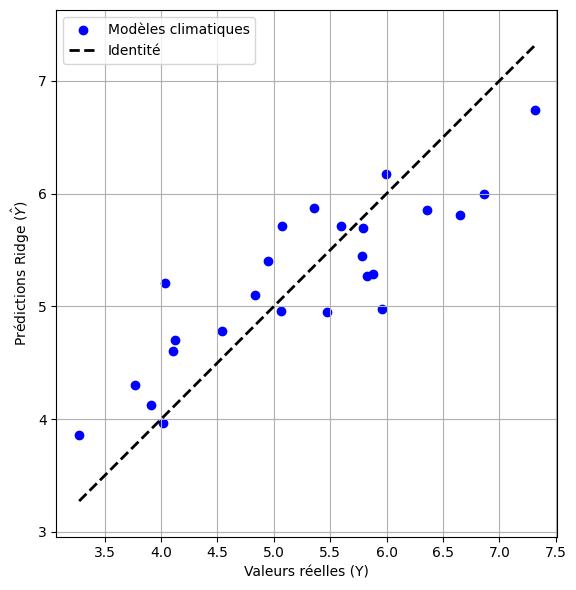

In [67]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

# Modèle Ridge
ridge = Ridge(alpha=1.0)
ridge.fit(X_multi, Y.ravel())

# Prédiction pour l'observation réelle
Y_ridge = ridge.predict(X_obs_multi).item()

# Prédictions sur les données d'entraînement et RMSE
Y_train_pred = ridge.predict(X_multi)
rmse_ridge = np.sqrt(mean_squared_error(Y, Y_train_pred))


print(f"Projection Ridge : {Y_ridge:.3f} °C")
print(f"Incertitude (RMSE) : {rmse_ridge:.3f} °C")

# Prédictions Ridge déjà faites sur X_multi
plt.figure(figsize=(6, 6))
plt.scatter(Y, Y_train_pred, color='blue', label='Modèles climatiques')
plt.plot([Y.min(), Y.max()], [Y.min(), Y.max()], 'k--', lw=2, label='Identité')

plt.xlabel("Valeurs réelles (Y)")
plt.ylabel("Prédictions Ridge ($\hat{Y}$)")
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.tight_layout()
plt.show()


Projection Random Forest : 5.416 °C
Incertitude (RMSE) : 0.282 °C


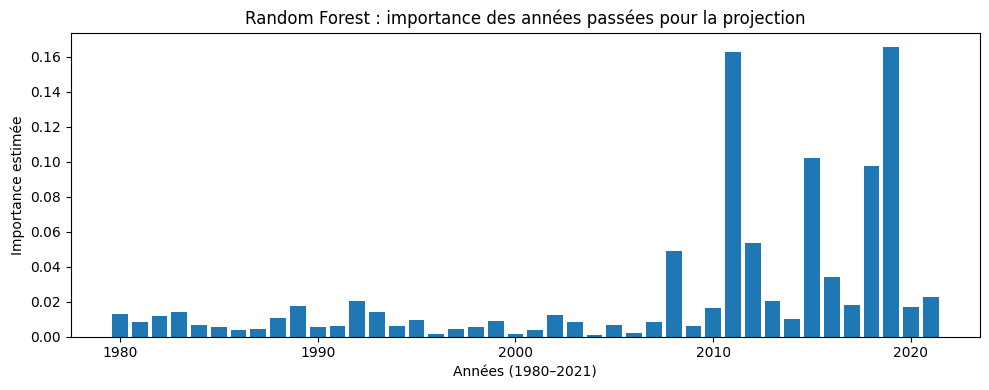

In [66]:
from sklearn.ensemble import RandomForestRegressor

# Modèle Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_multi, Y.ravel())

# Prédiction
Y_rf = rf.predict(X_obs_multi).item()

# Évaluation (sur les données d'entraînement)
Y_train_rf = rf.predict(X_multi)
rmse_rf = np.sqrt(mean_squared_error(Y, Y_train_rf))

print(f"Projection Random Forest : {Y_rf:.3f} °C")
print(f"Incertitude (RMSE) : {rmse_rf:.3f} °C")

# Liste des années utilisées comme prédicteurs
years_used = np.arange(1980, 2022)

# Importances des features
importances = rf.feature_importances_

# Plot
plt.figure(figsize=(10, 4))
plt.bar(years_used, importances)
plt.xlabel("Années (1980–2021)")
plt.ylabel("Importance estimée")
plt.title("Random Forest : importance des années passées pour la projection")
plt.tight_layout()
plt.show()


In [64]:
from sklearn.neighbors import KNeighborsRegressor

# Modèle k-NN
knn = KNeighborsRegressor(n_neighbors=3)
knn.fit(X_multi, Y.ravel())

# Prédiction
Y_knn = knn.predict(X_obs_multi).item()

# Évaluation (sur les données d'entraînement)
Y_train_knn = knn.predict(X_multi)
rmse_knn = np.sqrt(mean_squared_error(Y, Y_train_knn))

print(f"Projection k-NN : {Y_knn:.3f} °C")
print(f"Incertitude (RMSE) : {rmse_knn:.3f} °C")


Projection k-NN : 5.575 °C
Incertitude (RMSE) : 0.645 °C


## ACP

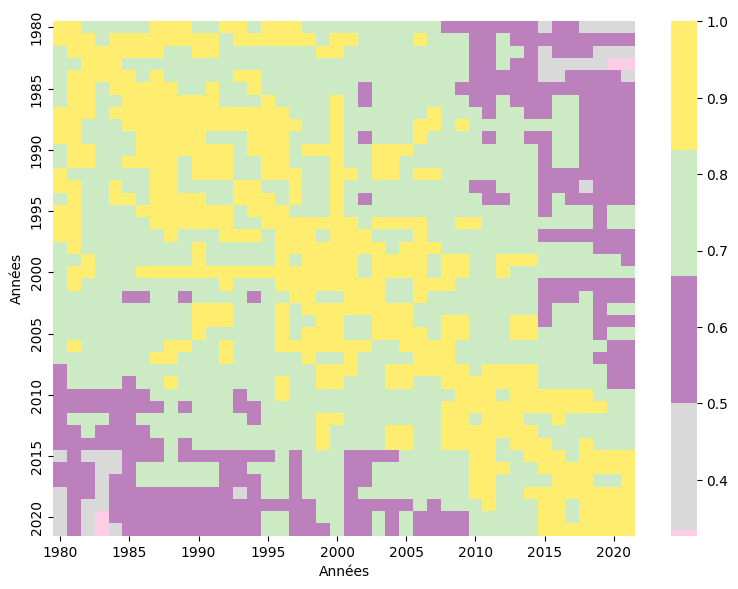

1 composantes → 76.150% de variance expliquée
2 composantes → 84.533% de variance expliquée
3 composantes → 87.707% de variance expliquée
4 composantes → 89.600% de variance expliquée
5 composantes → 91.167% de variance expliquée
6 composantes → 92.684% de variance expliquée
7 composantes → 94.003% de variance expliquée
8 composantes → 94.816% de variance expliquée
9 composantes → 95.599% de variance expliquée
10 composantes → 96.196% de variance expliquée
11 composantes → 96.751% de variance expliquée
12 composantes → 97.231% de variance expliquée
13 composantes → 97.661% de variance expliquée
14 composantes → 98.077% de variance expliquée
15 composantes → 98.453% de variance expliquée
16 composantes → 98.756% de variance expliquée
17 composantes → 99.032% de variance expliquée
18 composantes → 99.277% de variance expliquée
19 composantes → 99.471% de variance expliquée
20 composantes → 99.644% de variance expliquée
21 composantes → 99.784% de variance expliquée
22 composantes → 99.88

In [120]:
from sklearn.decomposition import PCA
import seaborn as sns

# Standardisation
X_std = (X_multi - X_multi.mean(axis=0)) / X_multi.std(axis=0,ddof=1)
X_obs_std = (X_obs_multi - X_multi.mean(axis=0)) / X_multi.std(axis=0,ddof=1)

# ACP
pca = PCA()
X_pca = pca.fit_transform(X_std)
X_obs_pca = pca.transform(X_obs_std)


# Création d'un DataFrame pour nommer les colonnes par les années
years = np.arange(1980, 2022)
df_years = pd.DataFrame(X_multi, columns=years)

# Calcul de la matrice de corrélation
corr_matrix = df_years.corr()

# Affichage de la heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, cmap='Set3', center=0, xticklabels=5, yticklabels=5)

plt.xlabel("Années")
plt.ylabel("Années")
plt.tight_layout()
plt.show()

# Valeurs propres : variance expliquée par chaque composante principale
explained_variance_ratio = pca.explained_variance_ratio_

cumulative_variance = np.cumsum(explained_variance_ratio)

for i, val in enumerate(cumulative_variance):
    print(f"{i+1} composantes → {val:.3%} de variance expliquée")

In [124]:
# réduction à 5 composantes principales
n_components = 5
X_ACP = X_pca[:, :n_components]                   # shape (25, 5)
X_obs_ACP = X_obs_pca[:, :n_components]           # shape (1, 5)

# Vérification
print(f"X_ACP shape : {X_ACP.shape}")
print(f"X_obs_ACP shape : {X_obs_ACP.shape}")
np.shape(X_multi)

X_ACP shape : (25, 5)
X_obs_ACP shape : (1, 5)


(25, 42)

## Feature selection par variance

In [129]:
# 1. Sélection par variance (la plus simple ici)
variances_acp = X_ACP.var(axis=0)
idx_max_var_acp = np.argmax(variances_acp)

X_acp_var = X_ACP[:, idx_max_var_acp].reshape(-1, 1)
X_obs_acp_var = X_obs_ACP[:, idx_max_var_acp].reshape(1, 1)

print(f"Composante sélectionnée par variance : PC{idx_max_var_acp + 1}")

Composante sélectionnée par variance : PC1


## Sélection par corrélation avec la cible Y

In [127]:
# 2. Sélection par corrélation avec Y
correlations_acp = np.array([np.corrcoef(X_ACP[:, j], Y.ravel())[0, 1] for j in range(X_ACP.shape[1])])
idx_max_corr_acp = np.argmax(np.abs(correlations_acp))

X_acp_corr = X_ACP[:, idx_max_corr_acp].reshape(-1, 1)
X_obs_acp_corr = X_obs_ACP[:, idx_max_corr_acp].reshape(1, 1)

print(f"Composante sélectionnée par corrélation : PC{idx_max_corr_acp + 1}")
print(f"Corrélation avec Y : {correlations_acp[idx_max_corr_acp]:.3f}")

Composante sélectionnée par corrélation : PC2
Corrélation avec Y : 0.591


# méthodes univariés finales

In [167]:
# --- Données à tester ---
projections = [
    ("PC1 (variance)", X_acp_var, X_obs_acp_var, range(130, 172)),  # 1980–2021
    ("PC2 (corrélation)", X_acp_corr, X_obs_acp_corr, range(130, 172))
]

# --- Paramètres pour la moyenne pondérée ---
sigma_values = [(0.1, 0.1)]

# --- Lancement des 3 méthodes pour chaque projection ---
for label, X_proj, X_obs_proj, idx_range in projections:
    print(f"\n==== Projection sur {label} ====")
    
    # Régression linéaire
    regression_lineaire(X_proj, Y, X_obs_proj, label)
    
    # Calcul du R²
    model = LinearRegression().fit(X_proj, Y)
    r2 = model.score(X_proj, Y)
    print(f"{label} — Coefficient de détermination R² : {r2:.3f}")
    
    # Moyenne pondérée
    for sigma_D, sigma_S in sigma_values:
        moyenne_ponderee_resultats(X_proj, X_obs_proj, Y, label + f" — σ_D={sigma_D}, σ_S={sigma_S}")
    
    # One-step Kalman
    kalman_projection(X_proj, Y, X_obs_proj, matrix_4, idx_range, label)


==== Projection sur PC1 (variance) ====
PC1 (variance) — Modèle : Y = 0.071 * X + 5.221
PC1 (variance) — Prédiction à partir de X_obs : 5.362 °C
PC1 (variance) — Incertitude associée (écart-type) : 0.212 °C

PC1 (variance) — Coefficient de détermination R² : 0.145
--- PC1 (variance) — σ_D=0.1, σ_S=0.1 ---
σ_D=0.1, σ_S=0.1 → Ŷ = 5.956 °C, σ̂ = 0.000 °C

PC1 (variance) — Projection Kalman : 5.358 °C
PC1 (variance) — Incertitude associée : 0.978 °C


==== Projection sur PC2 (corrélation) ====
PC2 (corrélation) — Modèle : Y = 0.333 * X + 5.221
PC2 (corrélation) — Prédiction à partir de X_obs : 4.576 °C
PC2 (corrélation) — Incertitude associée (écart-type) : 0.253 °C

PC2 (corrélation) — Coefficient de détermination R² : 0.350
--- PC2 (corrélation) — σ_D=0.1, σ_S=0.1 ---
σ_D=0.1, σ_S=0.1 → Ŷ = 3.782 °C, σ̂ = 0.056 °C

PC2 (corrélation) — Projection Kalman : 4.732 °C
PC2 (corrélation) — Incertitude associée : 0.853 °C



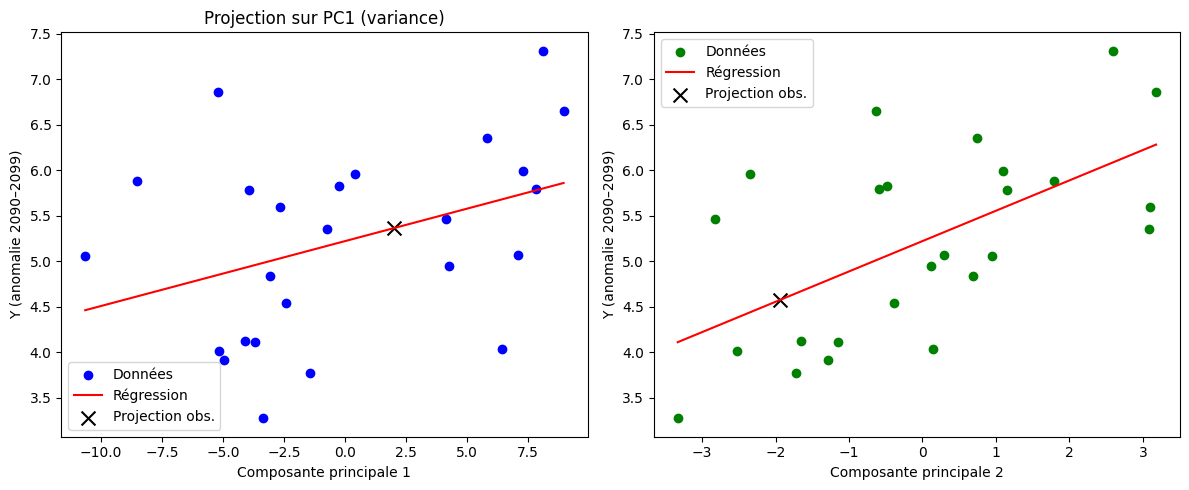

In [161]:
# Modèles de régression
model_PC1 = LinearRegression().fit(X_acp_var, Y)
model_PC2 = LinearRegression().fit(X_acp_corr, Y)

# Données pour tracer la droite (PC1 et PC2)
x_vals_PC1 = np.linspace(X_acp_var.min(), X_acp_var.max(), 100).reshape(-1, 1)
x_vals_PC2 = np.linspace(X_acp_corr.min(), X_acp_corr.max(), 100).reshape(-1, 1)

y_vals_PC1 = model_PC1.predict(x_vals_PC1)
y_vals_PC2 = model_PC2.predict(x_vals_PC2)

# Tracé
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# ----------- Plot PC1 ------------
axs[0].scatter(X_acp_var, Y, color='blue', label='Données')
axs[0].plot(x_vals_PC1, y_vals_PC1, color='red', label='Régression')
axs[0].scatter(X_obs_acp_var, model_PC1.predict(X_obs_acp_var), color='black', marker='x', s=100, label='Projection obs.')
axs[0].set_title("Projection sur PC1 (variance)")
axs[0].set_xlabel("Composante principale 1")
axs[0].set_ylabel("Y (anomalie 2090–2099)")
axs[0].legend()

# ----------- Plot PC2 ------------
axs[1].scatter(X_acp_corr, Y, color='green', label='Données')
axs[1].plot(x_vals_PC2, y_vals_PC2, color='red', label='Régression')
axs[1].scatter(X_obs_acp_corr, model_PC2.predict(X_obs_acp_corr), color='black', marker='x', s=100, label='Projection obs.')
#axs[1].set_title("Projection sur PC2 (corrélation)")
axs[1].set_xlabel("Composante principale 2")
axs[1].set_ylabel("Y (anomalie 2090–2099)")
axs[1].legend()

plt.tight_layout()
plt.show()